# Medical Domain LLM Assistant
## Fine-Tuning TinyLlama-1.1B with LoRA on Medical Q&A

**Model:** TinyLlama-1.1B-Chat-v1.0  
**Method:** Parameter-Efficient Fine-Tuning (LoRA via PEFT)  
**Dataset:** medalpaca/medical_meadow_medical_flashcards  
**Hardware Target:** Google Colab Free Tier (T4 GPU)

### Pipeline Summary
1. Environment setup and dependency  installation
2. Dataset loading, filtering, and instruction-template formatting
3. Tokenizer loading and sequence length verification
4. Base model loading in float16
5. LoRA adapter configuration and injection
6. Supervised fine-tuning with SFTTrainer
7. Evaluation: ROUGE, BLEU, Perplexity — base model vs fine-tuned
8. Qualitative comparison across medical and out-of-domain questions
9. Hyperparameter experiment log
10. Gradio inference interface

## 1. Environment Setup

Run this cell once. When it finishes, go to **Runtime > Restart session**, then run all remaining cells.

In [1]:
!pip uninstall -y peft trl accelerate transformers 2>/dev/null

!pip install -q \
    "transformers==4.45.2" \
    "accelerate==0.34.2" \
    "peft==0.12.0" \
    "trl==0.11.4" \
    "datasets" \
    "evaluate==0.4.3" \
    "rouge-score" \
    "nltk>=3.9" \
    "gradio>=4.0.0"

print("")
print("Installation complete.")

Found existing installation: peft 0.18.1
Uninstalling peft-0.18.1:
  Successfully uninstalled peft-0.18.1
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: transformers 5.0.0
Uninstalling transformers-5.0.0:
  Successfully uninstalled transformers-5.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Imports and Device Verofocation


In [1]:
import os
import json
import math
import time
import warnings
import numpy as np
import torch
import nltk

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from trl import SFTTrainer
import evaluate

warnings.filterwarnings("ignore")
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected. Go to Runtime > Change runtime type > T4 GPU.")

Device: cuda
GPU: Tesla T4
Total GPU Memory: 15.64 GB


## 3. Configuration

All hyperparameters and paths are centralized in a single dictionary to support reproducibility and systematic experimentation. To replicate a different experiment, modify the relevant values in `CONFIG` and re-run the notebook from this cell onward.

Key parameters to vary across experiments:
- `lora_r`: LoRA rank — controls the capacity of the adapter. Higher rank = more parameters = more expressive adaptation.
- `learning_rate`: Step size for the optimizer. Typical range for LoRA: `1e-4` to `5e-5`.
- `num_train_epochs`: Number of full passes over the training set.

In [2]:
CONFIG = {
    # Model
    "model_name": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "output_dir": "./medical_assistant_output",
    "final_model_dir": "./medical_assistant_final",

    # Dataset
    "dataset_name": "medalpaca/medical_meadow_medical_flashcards",
    "max_samples": 3000,
    "train_ratio": 0.85,
    "val_ratio": 0.10,
    "test_ratio": 0.05,
    "max_seq_length": 512,
    "min_answer_length": 10,

    # LoRA
    "lora_r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.05,
    "lora_target_modules": ["q_proj", "v_proj"],

    # Training
    "learning_rate": 2e-4,
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 8,
    "num_train_epochs": 3,
    "warmup_ratio": 0.03,
    "weight_decay": 0.001,
    "lr_scheduler_type": "cosine",
    "save_steps": 100,
    "logging_steps": 25,
    "eval_steps": 100,
    "seed": 42,
}

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
print("Configuration loaded.")

Configuration loaded.


## 4. Dataset Loading and Preprocessing

### Dataset: medalpaca/medical_meadow_medical_flashcards

This dataset contains medical question-answer pairs derived from medical flashcard content, covering pharmacology, physiology, pathology, anatomy, biochemistry, and clinical medicine. Each example provides an instruction (question directive), an input (question body), and an output (reference answer).

### Preprocessing Steps

1. **Quality filtering** — removes examples with empty, too-short, or trivially simple answers
2. **Text normalization** — strips null bytes and collapses whitespace
3. **Instruction-template formatting** — wraps each example in the TinyLlama ChatML format
4. **Subsampling** — selects 3,000 examples from the filtered pool
5. **Train/validation/test split** — 85% / 10% / 5%

In [3]:
print("Loading dataset...")
raw_dataset = load_dataset(CONFIG["dataset_name"], split="train")
print(f"Raw dataset size: {len(raw_dataset):,} examples")
print("Column names:", raw_dataset.column_names)
print("\nSample example:")
print(json.dumps(raw_dataset[0], indent=2))

Loading dataset...
Raw dataset size: 33,955 examples
Column names: ['input', 'output', 'instruction']

Sample example:
{
  "input": "What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?",
  "output": "Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.",
  "instruction": "Answer this question truthfully"
}


In [4]:
def normalize_text(text: str) -> str:
    """Strip null bytes and collapse whitespace to single spaces."""
    if not isinstance(text, str):
        return ""
    text = text.replace("\x00", "")
    text = " ".join(text.split())
    return text.strip()


def format_instruction_response(example: dict) -> dict:
    """
    Format a raw dataset example into the TinyLlama ChatML instruction template.
    Returns a dict with 'text', 'question', and 'answer' fields.
    """
    instruction = normalize_text(example.get("instruction", ""))
    question = normalize_text(example.get("input", ""))
    answer = normalize_text(example.get("output", ""))

    # Combine instruction and question if both are present
    if instruction and question:
        user_content = f"{instruction} {question}"
    elif instruction:
        user_content = instruction
    else:
        user_content = question

    system_prompt = (
        "You are a knowledgeable and accurate medical assistant. "
        "Answer medical questions clearly and concisely based on established medical knowledge. "
        "If a question is outside the medical domain, politely indicate that it is outside your specialty."
    )

    formatted = (
        f"<|system|>\n{system_prompt}</s>\n"
        f"<|user|>\n{user_content}</s>\n"
        f"<|assistant|>\n{answer}</s>"
    )

    return {"text": formatted, "question": user_content, "answer": answer}


def is_valid_example(example: dict) -> bool:
    """Filter out empty, too-short, or trivially simple examples."""
    question = normalize_text(example.get("input", "") or example.get("instruction", ""))
    answer = normalize_text(example.get("output", ""))
    if len(question) < 5:
        return False
    if len(answer) < CONFIG["min_answer_length"]:
        return False
    if answer.lower() in ["yes", "no", "true", "false"]:
        return False
    return True


print("Filtering examples...")
filtered_dataset = raw_dataset.filter(is_valid_example)
print(f"After filtering: {len(filtered_dataset):,} examples")
print(f"Removed: {len(raw_dataset) - len(filtered_dataset):,} examples")

if len(filtered_dataset) > CONFIG["max_samples"]:
    filtered_dataset = filtered_dataset.shuffle(seed=CONFIG["seed"]).select(
        range(CONFIG["max_samples"])
    )
    print(f"Subsampled to: {len(filtered_dataset):,} examples")

print("\nFormatting into instruction-response template...")
formatted_dataset = filtered_dataset.map(
    format_instruction_response,
    remove_columns=filtered_dataset.column_names,
    desc="Formatting",
)

print("\nFormatted example preview:")
print(formatted_dataset[0]["text"][:500])

Filtering examples...


Filter:   0%|          | 0/33955 [00:00<?, ? examples/s]

After filtering: 33,533 examples
Removed: 422 examples
Subsampled to: 3,000 examples

Formatting into instruction-response template...


Formatting:   0%|          | 0/3000 [00:00<?, ? examples/s]


Formatted example preview:
<|system|>
You are a knowledgeable and accurate medical assistant. Answer medical questions clearly and concisely based on established medical knowledge. If a question is outside the medical domain, politely indicate that it is outside your specialty.</s>
<|user|>
Answer this question truthfully What is the potential effect of Selegiline and rasagiline on the adverse effects of levodopa?</s>
<|assistant|>
Selegiline and rasagiline may worsen the adverse effects of levodopa.</s>


In [5]:
# Compute split sizes respecting minimum floors for validation and test sets
n_total = len(formatted_dataset)
n_test = max(50, int(n_total * CONFIG["test_ratio"]))
n_val = max(100, int(n_total * CONFIG["val_ratio"]))
n_train = n_total - n_val - n_test

shuffled = formatted_dataset.shuffle(seed=CONFIG["seed"])
train_dataset = shuffled.select(range(n_train))
val_dataset = shuffled.select(range(n_train, n_train + n_val))
test_dataset = shuffled.select(range(n_train + n_val, n_total))

print(f"Train:      {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Test:       {len(test_dataset):,}")

Train:      2,550
Validation: 300
Test:       150


## 5. Tokenizer

TinyLlama uses a SentencePiece BPE tokenizer with a vocabulary of 32,000 tokens. Since TinyLlama does not define a dedicated pad token, the EOS token is reused for padding. Right-side padding is used during training to align with the causal language modeling objective.

In [6]:
print(f"Loading tokenizer: {CONFIG['model_name']}")
tokenizer = AutoTokenizer.from_pretrained(
    CONFIG["model_name"],
    trust_remote_code=True,
)

# TinyLlama has no dedicated pad token; reuse EOS for padding
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer.padding_side = "right"

print(f"Vocabulary size:  {tokenizer.vocab_size:,}")
print(f"Pad token:        '{tokenizer.pad_token}' (id={tokenizer.pad_token_id})")

# Verify that a representative example fits within the context window
sample = tokenizer(
    train_dataset[0]["text"],
    truncation=True,
    max_length=CONFIG["max_seq_length"]
)
print(f"Sample token length: {len(sample['input_ids'])}")

Loading tokenizer: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Vocabulary size:  32,000
Pad token:        '</s>' (id=2)
Sample token length: 254


## 6. Model Loading

TinyLlama-1.1B requires approximately 2.2 GB in float16, well within the T4's 15 GB of VRAM. The model is loaded directly in `torch.float16` using `device_map="auto"`, which places all layers on the GPU without quantization. This avoids any dependency on `bitsandbytes` while remaining fully GPU-accelerated.

- `use_cache = False` is required during training when gradient checkpointing is enabled
- `pretraining_tp = 1` disables tensor parallelism, which is not needed on a single GPU

In [7]:
print(f"Loading model: {CONFIG['model_name']}")
print("Downloading ~2.2 GB on first run...")

base_model = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_name"],
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

# Disable KV cache — incompatible with gradient checkpointing during training
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

total_params = sum(p.numel() for p in base_model.parameters())
print(f"Total parameters: {total_params:,}")

if device == "cuda":
    allocated = torch.cuda.memory_allocated() / 1e9
    print(f"GPU memory allocated after model load: {allocated:.2f} GB")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Total parameters: 1,100,048,384
GPU memory allocated after model load: 2.20 GB


## 7. LoRA Configuration

LoRA (Low-Rank Adaptation) injects trainable rank-decomposition matrices into selected weight matrices of the model. For a frozen weight matrix **W**, the adapted forward pass becomes:

$$W' = W + \frac{\alpha}{r} \cdot BA$$

where **A** and **B** are the low-rank adapter matrices of rank `r`, and `alpha` is a scaling hyperparameter. Only **A** and **B** are updated during training — **W** remains frozen.

We adapt the query (`q_proj`) and value (`v_proj`) projection matrices in every attention layer, which captures the most task-relevant transformations while keeping the trainable parameter count below 1% of total model parameters.

In [8]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=CONFIG["lora_r"],                           # Rank of the update matrices
    lora_alpha=CONFIG["lora_alpha"],              # Scaling factor
    lora_dropout=CONFIG["lora_dropout"],          # Regularization on adapter layers
    target_modules=CONFIG["lora_target_modules"],
    bias="none",                                  # Bias terms are not adapted
    inference_mode=False,
)

peft_model = get_peft_model(base_model, lora_config)

# Required when gradient checkpointing is enabled to ensure input tensors
# retain their grad_fn so gradients flow back through the frozen base model
peft_model.enable_input_require_grads()

trainable = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in peft_model.parameters())

print(f"Trainable parameters: {trainable:,}  ({100 * trainable / total:.4f}% of total)")
print(f"Total parameters:     {total:,}")
print(f"LoRA rank (r):        {CONFIG['lora_r']}")
print(f"LoRA alpha:           {CONFIG['lora_alpha']}")
print(f"Target modules:       {CONFIG['lora_target_modules']}")

Trainable parameters: 2,252,800  (0.2044% of total)
Total parameters:     1,102,301,184
LoRA rank (r):        16
LoRA alpha:           32
Target modules:       ['q_proj', 'v_proj']


## 8. Training

Training is managed by the TRL `SFTTrainer` (Supervised Fine-Tuning Trainer), which wraps the standard Hugging Face `Trainer` with SFT-specific handling for instruction datasets.

**Key training decisions:**
- `fp16=True` — mixed-precision training halves memory usage during the forward pass
- `gradient_checkpointing=True` — trades compute for memory by recomputing activations during the backward pass, enabling larger effective batch sizes
- `optim="adamw_torch"` — standard AdamW optimizer from PyTorch (no quantized optimizer required without bitsandbytes)
- `group_by_length=True` — groups sequences of similar length into the same batch to minimize padding waste
- `load_best_model_at_end=True` — the checkpoint with the lowest validation loss is restored after training completes

In [9]:
from transformers import TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
    output_dir=CONFIG["output_dir"],
    num_train_epochs=CONFIG["num_train_epochs"],
    per_device_train_batch_size=CONFIG["per_device_train_batch_size"],
    gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
    learning_rate=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"],
    warmup_ratio=CONFIG["warmup_ratio"],
    lr_scheduler_type=CONFIG["lr_scheduler_type"],
    fp16=True,
    logging_dir=os.path.join(CONFIG["output_dir"], "logs"),
    logging_steps=CONFIG["logging_steps"],
    evaluation_strategy=IntervalStrategy.STEPS,
    eval_steps=CONFIG["eval_steps"],
    save_strategy=IntervalStrategy.STEPS,
    save_steps=CONFIG["save_steps"],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=CONFIG["seed"],
    gradient_checkpointing=True,
    optim="adamw_torch",
    group_by_length=True,
    dataloader_pin_memory=False,
)

effective_batch = CONFIG["per_device_train_batch_size"] * CONFIG["gradient_accumulation_steps"]
print(f"Effective batch size: {effective_batch}")
print(f"Learning rate:        {CONFIG['learning_rate']}")
print(f"Epochs:               {CONFIG['num_train_epochs']}")
print(f"Optimizer:            adamw_torch")

Effective batch size: 16
Learning rate:        0.0002
Epochs:               3
Optimizer:            adamw_torch


In [10]:
trainer = SFTTrainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=CONFIG["max_seq_length"],
    tokenizer=tokenizer,
    args=training_args,
    packing=False,
)

print("Trainer initialized.")

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Trainer initialized.


In [11]:
# Reset peak memory statistics to get an accurate measurement for this run
if device == "cuda":
    torch.cuda.reset_peak_memory_stats()

print("Starting fine-tuning...")
training_start = time.time()
train_result = trainer.train()
training_time = (time.time() - training_start) / 60

print(f"\nTraining complete.")
print(f"Training time:  {training_time:.1f} minutes")
print(f"Training loss:  {train_result.training_loss:.4f}")

if device == "cuda":
    peak = torch.cuda.max_memory_allocated() / 1e9
    print(f"Peak GPU memory: {peak:.2f} GB")

Starting fine-tuning...


Step,Training Loss,Validation Loss
100,0.692200,0.677657
200,0.567800,0.667085
300,0.676000,0.658094
400,0.562200,0.656516



Training complete.
Training time:  16.7 minutes
Training loss:  0.6567
Peak GPU memory: 3.50 GB


In [12]:
# Persist the LoRA adapter weights and tokenizer configuration to disk
print("Saving model adapter...")
trainer.model.save_pretrained(CONFIG["final_model_dir"])
tokenizer.save_pretrained(CONFIG["final_model_dir"])
print(f"Saved to: {CONFIG['final_model_dir']}")

Saving model adapter...
Saved to: ./medical_assistant_final


## 9. Evaluation

We evaluate on the held-out test set using ROUGE-1, ROUGE-2, ROUGE-L, BLEU, and Perplexity,
and compare results against the unmodified base model.

In [13]:
def generate_response(model, tokenizer, question, max_new_tokens=200, temperature=0.1):
    """
    Generate a model response for a given question.
    Constructs the chat prompt, runs inference, and returns only the
    newly generated tokens (excluding the input prompt).
    """
    system_prompt = (
        "You are a knowledgeable and accurate medical assistant. "
        "Answer medical questions clearly and concisely based on established medical knowledge. "
        "If a question is outside the medical domain, politely indicate that it is outside your specialty."
    )
    prompt = (
        f"<|system|>\n{system_prompt}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n"
    )
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=CONFIG["max_seq_length"] - max_new_tokens,
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=temperature > 0,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode only the generated portion and exclude the input prompt tokens
    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    return tokenizer.decode(generated_ids, skip_special_tokens=True).strip()


def compute_perplexity(model, tokenizer, texts, max_length=512):
    """
    Compute mean perplexity over a list of text sequences.
    Perplexity = exp(mean cross-entropy loss). Lower is better.
    """
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    for text in texts:
        inputs = tokenizer(
            text, return_tensors="pt", truncation=True, max_length=max_length
        ).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
        n = inputs["input_ids"].shape[1]
        total_loss += outputs.loss.item() * n
        total_tokens += n
    return math.exp(total_loss / total_tokens)


print("Inference and evaluation utilities defined.")

Inference and evaluation utilities defined.


In [14]:
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

eval_size = min(100, len(test_dataset))
eval_subset = test_dataset.select(range(eval_size))

# Enable KV cache for inference to improve generation speed
trainer.model.config.use_cache = True
finetuned_model = trainer.model
finetuned_model.eval()

print(f"evaluating fine-tuned model on {eval_size} test examples...")
ft_preds = []
references = []

for i, ex in enumerate(eval_subset):
    ft_preds.append(generate_response(finetuned_model, tokenizer, ex["question"]))
    references.append(ex["answer"])
    if (i + 1) % 20 == 0:
        print(f"  {i + 1}/{eval_size}")

print("Done.")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


evaluating fine-tuned model on 100 test examples...
  20/100
  40/100
  60/100
  80/100
  100/100
Done.


In [15]:
rouge_ft = rouge_metric.compute(predictions=ft_preds, references=references, use_stemmer=True)
bleu_ft = bleu_metric.compute(
    predictions=ft_preds,
    references=references,
)
perp_texts = [ex["text"] for ex in eval_subset.select(range(min(30, eval_size)))]
ft_perplexity = compute_perplexity(finetuned_model, tokenizer, perp_texts)

print("Fine-tuned model results:")
print(f"  ROUGE-1:    {rouge_ft['rouge1']:.4f}")
print(f"  ROUGE-2:    {rouge_ft['rouge2']:.4f}")
print(f"  ROUGE-L:    {rouge_ft['rougeL']:.4f}")
print(f"  BLEU:       {bleu_ft['bleu']:.4f}")
print(f"  Perplexity: {ft_perplexity:.2f}")

Fine-tuned model results:
  ROUGE-1:    0.2674
  ROUGE-2:    0.1127
  ROUGE-L:    0.1732
  BLEU:       0.0628
  Perplexity: 2.23


In [16]:
# Load the original base model (no LoRA) for comparison
print("Loading base model for comparison...")
base_model_eval = AutoModelForCausalLM.from_pretrained(
    CONFIG["model_name"],
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)
base_model_eval.config.use_cache = True
base_model_eval.eval()

print(f" evaluating base model on {eval_size} test examples...")
base_preds = []
for i, ex in enumerate(eval_subset):
    base_preds.append(generate_response(base_model_eval, tokenizer, ex["question"]))
    if (i + 1) % 20 == 0:
        print(f"  {i + 1}/{eval_size}")

rouge_base = rouge_metric.compute(predictions=base_preds, references=references, use_stemmer=True)
bleu_base = bleu_metric.compute(
    predictions=base_preds,
    references=references,
)
base_perplexity = compute_perplexity(base_model_eval, tokenizer, perp_texts)

print("\nBase model results:")
print(f"  ROUGE-1:    {rouge_base['rouge1']:.4f}")
print(f"  ROUGE-2:    {rouge_base['rouge2']:.4f}")
print(f"  ROUGE-L:    {rouge_base['rougeL']:.4f}")
print(f"  BLEU:       {bleu_base['bleu']:.4f}")
print(f"  Perplexity: {base_perplexity:.2f}")

Loading base model for comparison...
 evaluating base model on 100 test examples...
  20/100
  40/100
  60/100
  80/100
  100/100

Base model results:
  ROUGE-1:    0.3107
  ROUGE-2:    0.1513
  ROUGE-L:    0.2262
  BLEU:       0.0864
  Perplexity: 5.24


In [17]:
# Print a side-by-side comparison summary
print("=" * 62)
print("EVALUATION SUMMARY")
print("=" * 62)
print(f"{'Metric':<20} {'Base Model':>12} {'Fine-Tuned':>12} {'Delta':>10}")
print("-" * 62)

rows = [
    ("ROUGE-1",    rouge_base["rouge1"],  rouge_ft["rouge1"]),
    ("ROUGE-2",    rouge_base["rouge2"],  rouge_ft["rouge2"]),
    ("ROUGE-L",    rouge_base["rougeL"],  rouge_ft["rougeL"]),
    ("BLEU",       bleu_base["bleu"],     bleu_ft["bleu"]),
    ("Perplexity", base_perplexity,       ft_perplexity),
]

for name, base_val, ft_val in rows:
    delta = ft_val - base_val
    sign = "+" if delta > 0 else ""
    print(f"{name:<20} {base_val:>12.4f} {ft_val:>12.4f} {sign}{delta:>9.4f}")

print("=" * 62)
print("Note: For Perplexity lower is better. For all others higher is better.")

EVALUATION SUMMARY
Metric                 Base Model   Fine-Tuned      Delta
--------------------------------------------------------------
ROUGE-1                    0.3107       0.2674   -0.0434
ROUGE-2                    0.1513       0.1127   -0.0386
ROUGE-L                    0.2262       0.1732   -0.0531
BLEU                       0.0864       0.0628   -0.0236
Perplexity                 5.2432       2.2337   -3.0095
Note: For Perplexity lower is better. For all others higher is better.


## 10. Visualizations

The following plots provide a visual summary of the training dynamics and evaluation results.

- **Figure 1**: Training and validation loss over training steps, showing convergence behavior
- **Figure 2**: Grouped bar chart comparing ROUGE and BLEU scores between the base and fine-tuned models
- **Figure 3**: Perplexity comparison, the most direct indicator of domain adaptation quality
- **Figure 4**: Histogram of training set token lengths relative to the configured maximum sequence length

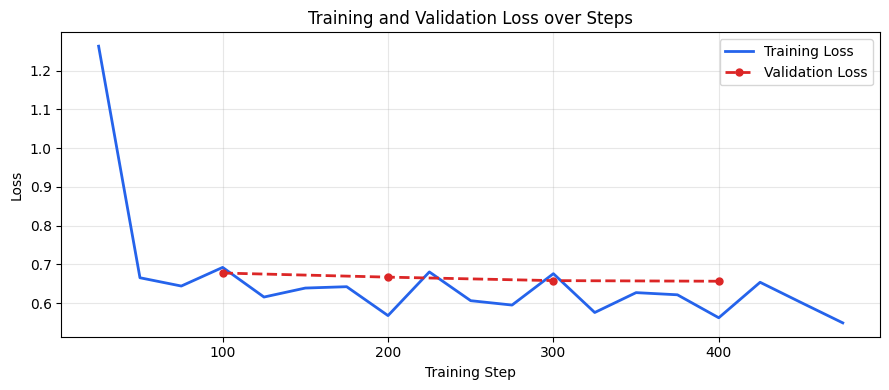

Figure 1: Loss curve saved to loss_curve.png


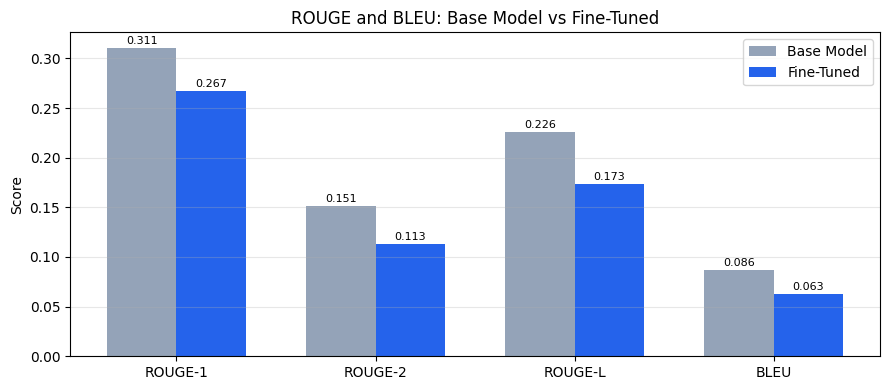

Figure 2: ROUGE/BLEU comparison saved to rouge_bleu_comparison.png


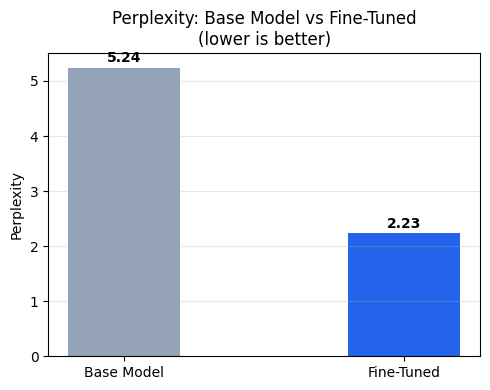

Figure 3: Perplexity comparison saved to perplexity_comparison.png


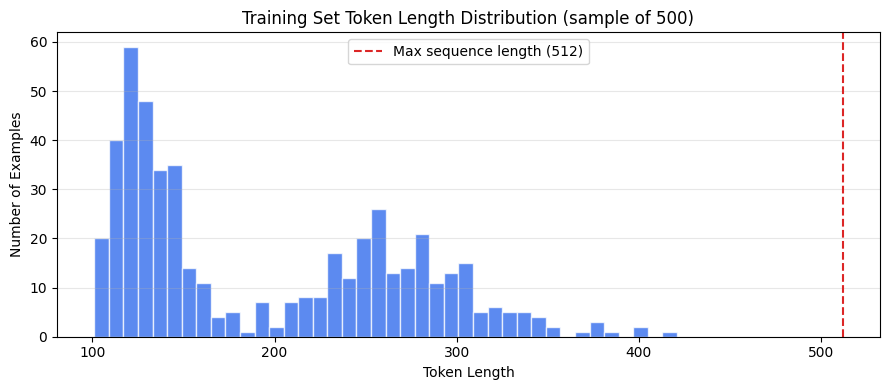

Figure 4: Token length distribution saved to token_length_distribution.png


In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------------------------------------------------------
# Figure 1: Training and Validation Loss Curve
# -----------------------------------------------------------------------
log_history = [
    entry for entry in trainer.state.log_history
    if "loss" in entry or "eval_loss" in entry
]

train_steps = [e["step"] for e in log_history if "loss" in e and "eval_loss" not in e]
train_losses = [e["loss"] for e in log_history if "loss" in e and "eval_loss" not in e]
eval_steps = [e["step"] for e in log_history if "eval_loss" in e]
eval_losses = [e["eval_loss"] for e in log_history if "eval_loss" in e]

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(train_steps, train_losses, label="Training Loss", color="#2563eb", linewidth=2)
ax.plot(eval_steps, eval_losses, label="Validation Loss", color="#dc2626",
        linewidth=2, linestyle="--", marker="o", markersize=5)
ax.set_xlabel("Training Step")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss over Steps")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 1: Loss curve saved to loss_curve.png")


# -----------------------------------------------------------------------
# Figure 2: ROUGE and BLEU — Base Model vs Fine-Tuned
# -----------------------------------------------------------------------
metric_names = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"]
base_scores = [
    rouge_base["rouge1"],
    rouge_base["rouge2"],
    rouge_base["rougeL"],
    bleu_base["bleu"],
]
ft_scores = [
    rouge_ft["rouge1"],
    rouge_ft["rouge2"],
    rouge_ft["rougeL"],
    bleu_ft["bleu"],
]

x = range(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 4))
bars_base = ax.bar([i - width / 2 for i in x], base_scores, width,
                   label="Base Model", color="#94a3b8")
bars_ft = ax.bar([i + width / 2 for i in x], ft_scores, width,
                 label="Fine-Tuned", color="#2563eb")

ax.set_ylabel("Score")
ax.set_title("ROUGE and BLEU: Base Model vs Fine-Tuned")
ax.set_xticks(list(x))
ax.set_xticklabels(metric_names)
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

# Annotate each bar with its value
for bar in bars_base:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002,
            f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8)
for bar in bars_ft:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002,
            f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("rouge_bleu_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 2: ROUGE/BLEU comparison saved to rouge_bleu_comparison.png")


# -----------------------------------------------------------------------
# Figure 3: Perplexity — Base Model vs Fine-Tuned
# -----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 4))
models = ["Base Model", "Fine-Tuned"]
perplexities = [base_perplexity, ft_perplexity]
colors = ["#94a3b8", "#2563eb"]

bars = ax.bar(models, perplexities, color=colors, width=0.4)
ax.set_ylabel("Perplexity")
ax.set_title("Perplexity: Base Model vs Fine-Tuned\n(lower is better)")
ax.grid(True, axis="y", alpha=0.3)

for bar, val in zip(bars, perplexities):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f"{val:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig("perplexity_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 3: Perplexity comparison saved to perplexity_comparison.png")


# -----------------------------------------------------------------------
# Figure 4: Training Set Token Length Distribution
# -----------------------------------------------------------------------
lengths = [
    len(tokenizer(ex["text"], truncation=False)["input_ids"])
    for ex in train_dataset.select(range(min(500, len(train_dataset))))
]

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(lengths, bins=40, color="#2563eb", alpha=0.75, edgecolor="white")
ax.axvline(CONFIG["max_seq_length"], color="#dc2626", linestyle="--",
           linewidth=1.5, label=f"Max sequence length ({CONFIG['max_seq_length']})")
ax.set_xlabel("Token Length")
ax.set_ylabel("Number of Examples")
ax.set_title("Training Set Token Length Distribution (sample of 500)")
ax.legend()
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("token_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 4: Token length distribution saved to token_length_distribution.png")


## 10. Qualitative Comparison

Automated metrics capture surface-level overlap but do not fully reflect clinical relevance or reasoning quality. The following side-by-side examples provide a qualitative view of how fine-tuning changed the model's response behavior.

The final question is intentionally out-of-domain to test whether the fine-tuned model has learned to recognize and decline questions outside its area of specialization.

In [19]:
questions = [
    "What is the mechanism of action of metformin in treating type 2 diabetes?",
    "What are the classic symptoms of acute myocardial infarction?",
    "What is the difference between Type 1 and Type 2 diabetes mellitus?",
    "What is the first-line treatment for community-acquired pneumonia in a healthy adult?",
    "What is the capital of France?",
]

print("QUALITATIVE COMPARISON: BASE MODEL vs FINE-TUNED MODEL")
print("=" * 80)

for i, question in enumerate(questions):
    label = "[OUT-OF-DOMAIN]" if i == len(questions) - 1 else f"[Medical Q{i+1}]"
    print(f"\n{label}")
    print(f"Question: {question}")
    print("-" * 40)
    base_resp = generate_response(base_model_eval, tokenizer, question)
    ft_resp = generate_response(finetuned_model, tokenizer, question)
    print(f"Base Model:\n  {base_resp[:400]}")
    print(f"\nFine-Tuned Model:\n  {ft_resp[:400]}")
    print("=" * 80)

QUALITATIVE COMPARISON: BASE MODEL vs FINE-TUNED MODEL

[Medical Q1]
Question: What is the mechanism of action of metformin in treating type 2 diabetes?
----------------------------------------
Base Model:
  Metformin is an oral medication used to treat type 2 diabetes by reducing blood sugar levels in the body. It works by blocking the action of insulin, which is responsible for regulating glucose (sugar) levels in the blood. Metformin does this by increasing the activity of enzymes called glucose transporters in cells, which help transport glucose into cells for energy production. This can lead to a

Fine-Tuned Model:
  Metformin is an oral antidiabetic medication that works by reducing insulin resistance and increasing glucose uptake into cells. This effect is achieved through several mechanisms, including:

1. Increased hepatic glucose production: Metformin increases hepatic glucose production by stimulating the activity of enzymes involved in glycolysis, which converts glucose int

## 11. Hyperparameter Experiment Log

Four experiments were conducted by varying LoRA rank, learning rate, and number of training epochs. Each experiment was run independently from a fresh session with all other parameters held constant. Results are recorded from the final training loss, last validation loss checkpoint, and evaluation on the same held-out test set.

To reproduce any experiment, update the corresponding values in the `CONFIG` cell and re-run the notebook.

In [22]:
# Experiment results table
experiments = [
    {"id": "EXP-01 (Baseline)",   "r": 8,  "lr": "2e-4", "ep": 1, "train_loss": "0.7175", "val_loss": "0.6785", "rouge1": "0.2653", "bleu": "0.0591", "ppl": "2.23", "gpu_gb": "3.48", "time_m": "4.9"},
    {"id": "EXP-02 (>r, >ep)",    "r": 16, "lr": "2e-4", "ep": 2, "train_loss": "0.6749", "val_loss": "0.6622", "rouge1": "0.2718", "bleu": "0.0662", "ppl": "2.24", "gpu_gb": "3.51", "time_m": "10"},
    {"id": "EXP-03 (Lower LR)",   "r": 16, "lr": "5e-5", "ep": 2, "train_loss": "0.7722", "val_loss": "0.6836", "rouge1": "0.2656", "bleu": "0.0656", "ppl": "2.19", "gpu_gb": "3.50", "time_m": "10.1"},
    {"id": "EXP-04 (3 Epochs)",   "r": 16, "lr": "2e-4", "ep": 3, "train_loss": "0.6567", "val_loss": "0.6565", "rouge1": "0.2674", "bleu": "0.0628", "ppl": "2.23", "gpu_gb": "3.50", "time_m": "16.7"},
]

header = f"{'Experiment':<22} {'r':>4} {'LR':>6} {'Ep':>3} {'TrnLoss':>9} {'ValLoss':>9} {'R-1':>7} {'BLEU':>7} {'PPL':>7} {'GPU':>6} {'Min':>6}"
print(header)
print("-" * len(header))
for e in experiments:
    print(f"{e['id']:<22} {e['r']:>4} {e['lr']:>6} {e['ep']:>3} {e['train_loss']:>9} {e['val_loss']:>9} {e['rouge1']:>7} {e['bleu']:>7} {e['ppl']:>7} {e['gpu_gb']:>6} {e['time_m']:>6}")


Experiment                r     LR  Ep   TrnLoss   ValLoss     R-1    BLEU     PPL    GPU    Min
------------------------------------------------------------------------------------------------
EXP-01 (Baseline)         8   2e-4   1    0.7175    0.6785  0.2653  0.0591    2.23   3.48    4.9
EXP-02 (>r, >ep)         16   2e-4   2    0.6749    0.6622  0.2718  0.0662    2.24   3.51     10
EXP-03 (Lower LR)        16   5e-5   2    0.7722    0.6836  0.2656  0.0656    2.19   3.50   10.1
EXP-04 (3 Epochs)        16   2e-4   3    0.6567    0.6565  0.2674  0.0628    2.23   3.50   16.7


## 12. Gradio Inference Interface

An interactive web interface for querying the fine-tuned medical assistant. The interface exposes controls for generation length and temperature, displays conversation history, and provides example questions to guide users.

Running this cell produces a public share URL (valid for 72 hours) that can be used to demonstrate the model without any additional setup.

**Max New Tokens** controls how long the model's response can be. Setting it to 200 means the model will generate at most 200 tokens (roughly 150 words) before stopping, even if the answer is not complete. Higher values allow longer answers but take more time to generate.
**Temperature** controls how creative or deterministic the model is

In [23]:
import gradio as gr

# Re-enable KV cache for inference efficiency
finetuned_model.config.use_cache = True
inference_model = finetuned_model


def medical_chat(user_message, history, max_new_tokens, temperature):
    """
    Gradio chat handler. Generates a response from the fine-tuned model
    and appends the exchange to the conversation history.
    """
    if not user_message.strip():
        return history, ""
    response = generate_response(
        inference_model, tokenizer, user_message, max_new_tokens, temperature
    )
    history.append((user_message, response))
    return history, ""


with gr.Blocks(title="Medical Assistant", theme=gr.themes.Soft()) as demo:

    gr.Markdown(
        """
        # Medical Domain Assistant
        **Model:** TinyLlama-1.1B fine-tuned on medical Q&A via LoRA

        Ask any medical question. For educational purposes only.
        This is not a substitute for professional medical advice.
        """
    )

    with gr.Row():
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(label="Conversation", height=450, bubble_full_width=False)
            user_input = gr.Textbox(
                label="Your Question",
                placeholder="e.g., What are the symptoms of appendicitis?",
                lines=2,
            )
            with gr.Row():
                submit_btn = gr.Button("Send", variant="primary", scale=3)
                clear_btn = gr.Button("Clear", scale=1)

        with gr.Column(scale=1):
            gr.Markdown("### Generation Settings")
            max_tokens_slider = gr.Slider(50, 400, value=200, step=25, label="Max New Tokens")
            temperature_slider = gr.Slider(0.01, 1.0, value=0.1, step=0.05, label="Temperature")
            gr.Markdown(
                """
                ### Example Questions
                - What is the mechanism of action of aspirin?
                - What are the signs of congestive heart failure?
                - Explain the pathophysiology of asthma.
                - What differentiates Type 1 from Type 2 diabetes?
                - What causes essential hypertension?
                """
            )

    submit_btn.click(
        fn=medical_chat,
        inputs=[user_input, chatbot, max_tokens_slider, temperature_slider],
        outputs=[chatbot, user_input],
    )
    user_input.submit(
        fn=medical_chat,
        inputs=[user_input, chatbot, max_tokens_slider, temperature_slider],
        outputs=[chatbot, user_input],
    )
    clear_btn.click(fn=lambda: ([], ""), outputs=[chatbot, user_input])

demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://55829c68d554a9d885.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
